In [2]:
from numba.cuda.cudadrv import enums
from numba import cuda

In [3]:
!wget -O img.jpeg https://file.io.vn/1H0WQ5

--2025-10-03 04:06:19--  https://file.io.vn/1H0WQ5
Resolving file.io.vn (file.io.vn)... 157.10.45.101
Connecting to file.io.vn (file.io.vn)|157.10.45.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://my.microsoftpersonalcontent.com/personal/de4e2fbd58f4f53b/_layouts/15/download.aspx?UniqueId=26cb7d04-61e0-4850-9d9e-e2cc88dc3055&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJiMWVkOTQ5Mi0wMDA3LTRhNWEtYjJmOC05MzA4OWQ4YzgwMmQiLCJhcHBfZGlzcGxheW5hbWUiOiJpaW5kZXgiLCJhcHBpZCI6ImQ4NWE5YTNhLTM4MzktNDkzMC05ZjE0LTgxOGEyZDQ0OWE0ZCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3NTk0Njc5ODMifQ.MZX_vlf_ObxmRbcv9JYgMNNu-O6SmCfUuE5oeNJfFBx8zZLqLp1iyQqVKhi2K9fq0Nb9Vr-E-A0JjJOlUuNlxulyvCFgBgJTPEojffGgfwKDIUqZl7H8t-A-OepEj8HSZEkp7v0n6QX_v_6sSEo1NXEj6v_czoyBk_VeOVhThOOYqrzKSks7uKZwqhFOb0YIi_vj55JrIOETOgtt8nbcC0jGVlPbVIpohYRYhsjL6S2h5R_zXDQ1G2yjkQuN0gDPK

In [4]:
# from matplotlib import pyplot
import matplotlib

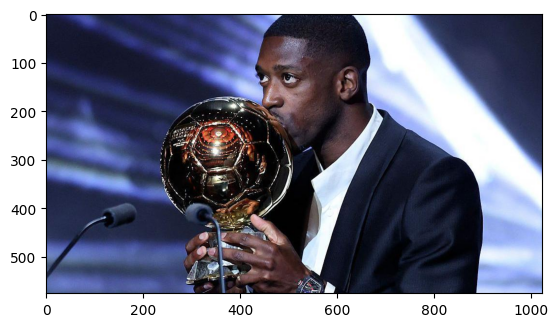

In [5]:
#Load the image
img = matplotlib.pyplot.imread('img.jpeg')

matplotlib.pyplot.imshow(img)

In [6]:
height, width, channels = img.shape
rgb_1d = img.reshape(height * width * 3)

In [7]:
import time

CPU time:  0.010538578033447266


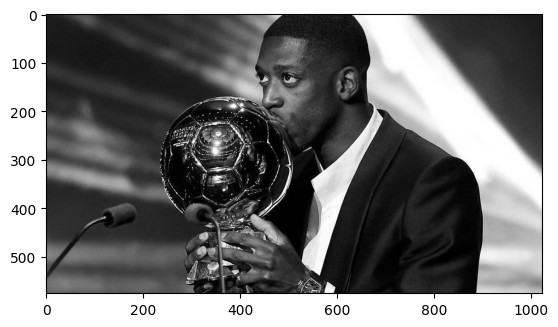

In [8]:
# CPU
start_time = time.time()
rgb_2d = rgb_1d.reshape(height, width, 3)
gray_2d = 0.299 * rgb_2d[:, :, 0] + 0.587 * rgb_2d[:, :, 1] + 0.114 * rgb_2d[:, :, 2]
end_time = time.time()
print("CPU time: ", end_time - start_time)
matplotlib.pyplot.imshow(gray_2d, cmap='gray')

In [9]:
from numba import jit, int32
import numpy as np
from numba import config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

In [10]:
@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  pixel_idx = tidx * 3
  if pixel_idx + 2 < src.shape[0]:
    g = np.uint8((src[pixel_idx] + src[pixel_idx + 1] + src[pixel_idx + 2]) / 3)
    dst[pixel_idx] = g
    dst[pixel_idx + 1] = g
    dst[pixel_idx + 2] = g

GPU time:  1.349064826965332


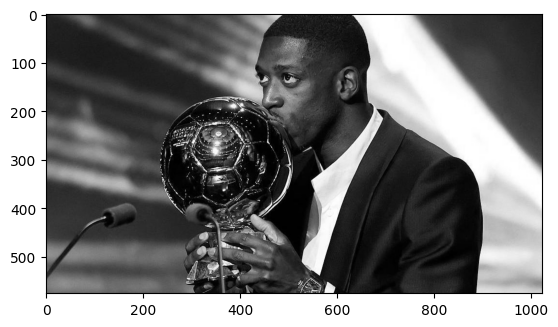

In [11]:
blockSize = 32
pixelCount = height * width
gridSize = (pixelCount + blockSize - 1) // blockSize

devSrc = cuda.to_device(rgb_1d)
devDst = cuda.device_array(height * width * 3, np.uint8)
start_time_gpu = time.time()
grayscale[gridSize, blockSize](devSrc, devDst)
end_time_gpu = time.time()
hostDst = devDst.copy_to_host()

print("GPU time: ", end_time_gpu - start_time_gpu)
matplotlib.pyplot.imshow(hostDst.reshape(height, width, 3), cmap='gray')

Block Size: 32, GPU time: 0.0003666877746582031 seconds
Block Size: 64, GPU time: 0.0002963542938232422 seconds
Block Size: 128, GPU time: 0.0002751350402832031 seconds
Block Size: 256, GPU time: 0.00025725364685058594 seconds
Block Size: 512, GPU time: 0.00025177001953125 seconds
Block Size: 1024, GPU time: 0.0002713203430175781 seconds


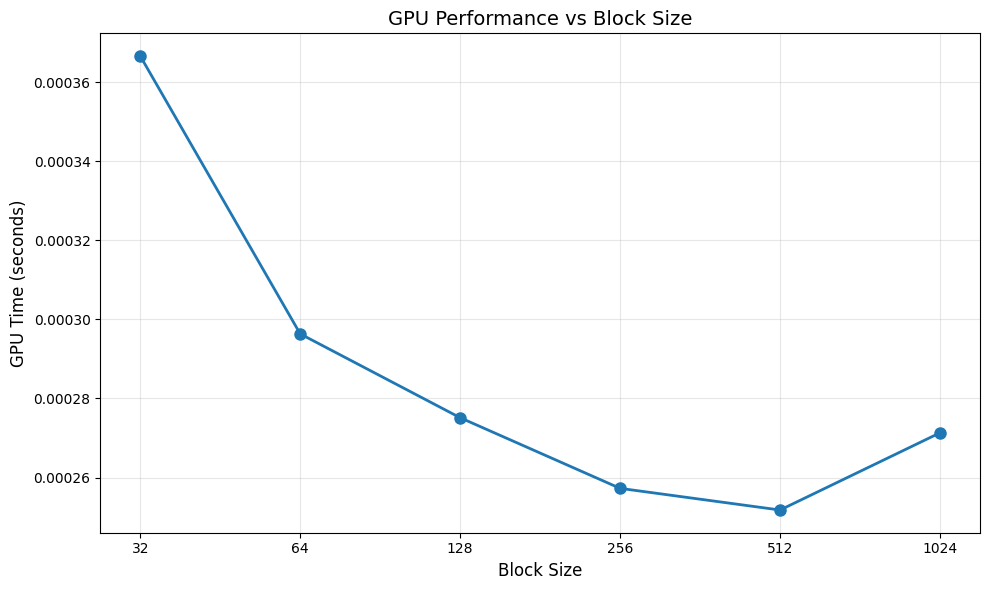

In [17]:
block_sizes = [32, 64, 128, 256, 512, 1024]
gpu_times = []

pixelCount = height * width

for blockSize in block_sizes:
    gridSize = (pixelCount + blockSize - 1) // blockSize

    devSrc = cuda.to_device(rgb_1d)
    devDst = cuda.device_array(height * width * 3, np.uint8)

    start_time_gpu = time.time()
    grayscale[gridSize, blockSize](devSrc, devDst)
    cuda.synchronize()
    end_time_gpu = time.time()

    gpu_time = end_time_gpu - start_time_gpu
    gpu_times.append(gpu_time)

    print(f"Block Size: {blockSize}, GPU time: {gpu_time} seconds")

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, gpu_times, marker='o', linewidth=2, markersize=8)
plt.xlabel('Block Size', fontsize=12)
plt.ylabel('GPU Time (seconds)', fontsize=12)
plt.title('GPU Performance vs Block Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(block_sizes, block_sizes)
plt.tight_layout()
plt.show()

In [16]:
best_idx = min(gpu_times)
print(best_idx)

0.0002467632293701172
